Zakładamy, że dziś jest **2018-03-28**. 
- $S^1_t$ - wartość indeksu **WIG20**.
- $S^2_t$ - wartość **KGHM**.
Zakładamy, że dynamika cen zachowuje się następująco:
$$ \log \left(\frac{S^i_{t+1}}{S^i_{t}}\right) = \alpha_i N^i_t + \beta_i, $$ gdzie 
$\alpha_i, \beta_i \in \mathbb{R}$, $N^i_t \sim \mathcal{N}(0, 1)$ 
oraz
- $N^i_t, N^j_s$ są nzl dla $t \neq s$ oraz dowolnych $i, j$.
- $N^1_t, N^2_t$ mają stąłą korelację $\rho$.


Rozważane opcje:
- A - notowana na GPW opcja EC(K = 2200, T = grudzień 2018) o symbolu: **OW20L182200** dnia 2018-03-28 warta  [147,55 PLN](https://www.gpw.pl/archiwum-notowan?fetch=0&type=66&instrument=OW20L182200&date=28-03-2018&show_x=Poka%C5%BC+wyniki)
- B
- C
- D
- E

Standardy opcji na GPW
- [standard](https://www.gpw.pl/pub/GPW/files/PDF/standardy_pl/Standard_opcje_WIG20_1.12.2019.pdf?fbclid=IwAR3dQYsMjxdt9OVWbk71_GaJYnhGbdAIBID11YPsod3HZc_UuLUrYyk2EcU)
- [KID opcje call](https://www.gpw.pl/pub/GPW/files/PDF/standardy_pl/KID/KID_GPW_opcje_long_short_call_PL.pdf?fbclid=IwAR3zCcHiYmQaMaKQ0N7y-nxYcPTs7o0R-gcXQRf2Byt9Y9nmPtxOPHFkDpQ)
- [KID opcje put](https://www.gpw.pl/pub/GPW/files/PDF/standardy_pl/KID/KID_GPW_opcje_long_short_put_PL.pdf?fbclid=IwAR35-JtY7MFxmiuVtmnreBshRFDtC_vviUXGNVFys6oSRLcGqTNJ29f-pos)

Nazwa skrócona opcji **OXYZkrrcccc**

Gdzie:
- O – rodzaj instrumentu,
- XYZ – kod określający nazwę instrumentu bazowego 
- k – kod określający typ i miesiąc wygaśnięcia opcji
- rr – dwie ostatnie cyfry roku wygaśnięcia,
- cccc – kurs wykonania

Miesiąc	Kod opcji kupna	Kod opcji sprzedaży

In [28]:
pd.DataFrame(np.array([['styczeń', 'A', 'M'],['luty'	,'B'	,'N'],['marzec'	,'C'	,'O'],['kwiecień'	,'D'	,'P'],['maj'	,'E'	,'Q'],['czerwiec'	,'F'	,'R'],['lipiec'	,'G'	,'S'],['sierpień'	,'H'	,'T'],['wrzesień'	,'I'	,'U'],['październik'	,'J'	,'V'],['listopad'	,'K'	,'W'],['grudzień'	,'L'	,'X'],]), columns=['miesiąc', 'call', 'put'])

,miesiąc,call,put
0,styczeń,A,M
1,luty,B,N
2,marzec,C,O
3,kwiecień,D,P
4,maj,E,Q
5,czerwiec,F,R
6,lipiec,G,S
7,sierpień,H,T
8,wrzesień,I,U
9,październik,J,V


In [140]:
import pandas as pd
import math
import numpy as np
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt
from google.colab import files
import matplotlib.mlab as mlab
import string


WIG_20 = np.array(["ACP","CDR","JSW","LTS","PEO","PKN","SPL","ALE","CPS","KGH","MRC","PGE","PKO","TPE","CCC","DNP","LPP","OPL","PGN","PZU"])
TRAINING_DATE_START = pd.to_datetime('2017-03-28')
TRAINING_DATE_END = pd.to_datetime('2018-03-27')
TODAY = pd.to_datetime('2018-03-28')
RISK_FREE_R = 0.03

In [47]:
def ReadAndPreprocess(url, ticker):
    data = pd.read_csv(url)
    data['Data'] = pd.to_datetime(data['Data'])
    data['Zwroty_dzienne'] = data['Zamkniecie'].pct_change()
    # log (S_{t+1} / S_t)
    data['Log_ratio'] = np.log(data['Zamkniecie']/ data['Zamkniecie'].shift(1))
    data['Company'] = ticker
    return data
  

def ReadWig20DailyPrices(url_prefix = 'https://raw.githubusercontent.com/wfica/stochastic-fin-maths/main/notowania_wig_20/',):
  df = pd.DataFrame()
  for company in WIG_20:
    url = url_prefix + company[:3].lower() + '_d.csv'
    data = ReadAndPreprocess(url, company)
    df = df.append(data, ignore_index=True)
  data = ReadAndPreprocess(url_prefix +'wig20_d.csv', 'W20')
  df = df.append(data, ignore_index=True)
  return df


wig_20_all = ReadWig20DailyPrices()

In [48]:
wig_20_all

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,Zwroty_dzienne,Log_ratio,Company
0,2015-06-02,43.613,43.750,43.361,43.361,301234.0,NaN,NaN,ACP
1,2015-06-03,43.470,44.190,43.002,43.002,379703.0,-0.008279,-0.008314,ACP
2,2015-06-05,42.315,42.698,41.098,41.133,161965.0,-0.043463,-0.044436,ACP
3,2015-06-08,41.494,42.423,41.278,42.207,237014.0,0.026110,0.025775,ACP
4,2015-06-09,42.207,42.885,41.485,42.244,136809.0,0.000877,0.000876,ACP
...,...,...,...,...,...,...,...,...,...
85127,2021-10-20,2447.070,2453.570,2432.330,2443.110,22261931.0,-0.001810,-0.001812,W20
85128,2021-10-21,2433.750,2433.750,2418.230,2427.350,18086091.0,-0.006451,-0.006472,W20
85129,2021-10-22,2425.020,2436.870,2412.570,2417.090,16121524.0,-0.004227,-0.004236,W20
85130,2021-10-25,2415.520,2430.620,2415.520,2427.190,16544470.0,0.004179,0.004170,W20


In [88]:
def ComputeModelParams(df=wig_20_all, start_date=TRAINING_DATE_START, end_date=TRAINING_DATE_END, tickers = np.append(WIG_20, 'W20')):
  stats = pd.DataFrame(columns=['Company', 'mean', 'std'])
  for i, ticker in enumerate(tickers):
    data = df[(df['Company'] == ticker) & (df['Data'] >= start_date) & (df['Data'] < end_date)]

    # Średnia i odchylenie standardowe
    mean = data['Zwroty_dzienne'].mean()
    std =  data['Zwroty_dzienne'].std()

    # Normujemy parametry
    trading_days = data.shape[0]
    mu = mean * trading_days
    sigma = std * math.sqrt(trading_days)
    
    stats.loc[i] = [ticker, mu, sigma]
  # stats = stats.set_index('Company')
  return stats

params = ComputeModelParams()

In [89]:
params

,Company,mean,std
0,ACP,-0.098013,0.237382
1,CDR,0.469464,0.372601
2,JSW,0.362118,0.365446
3,LTS,0.101120,0.350194
4,PEO,0.005175,0.209975
5,PKN,-0.071262,0.345428
6,SPL,0.106418,0.293260
7,ALE,NaN,NaN
8,CPS,0.060417,0.229678
9,KGH,-0.244517,0.303003


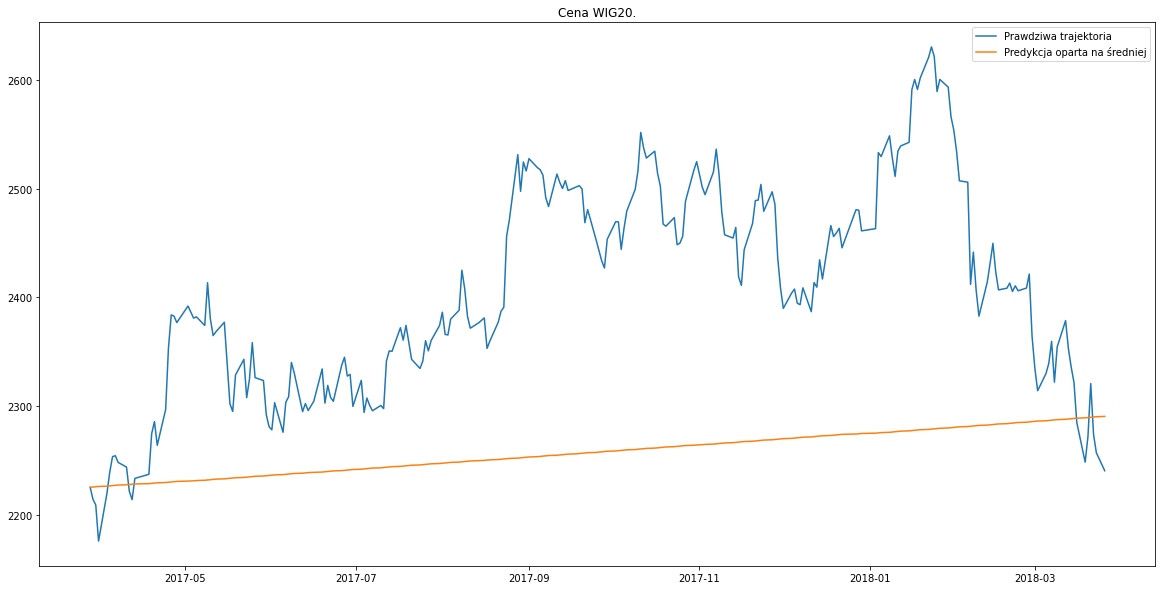

In [118]:
# Confirm that mu is reasonable.

def MuBasedPred(_trading_days, , plot_start, ticker = 'W20'):
  # _trading_days = wig_20_plot['Data'].shape[0]
  _dt = 1./_trading_days
  init_price = wig_20_all[ (wig_20_all['Data'] == plot_start) & (wig_20_all['Company'] == ticker)]['Zamkniecie'].item()
  estimated_mu = params[params['Company'] == ticker]['mean'].item()

  simple_preds = np.full(_trading_days, wig20_init_price)
  for i in range(1, _trading_days):
    simple_preds[i] = simple_preds[i-1] * (1. + estimated_mu*_dt)
  return simple_preds 

plot_start = TRAINING_DATE_START
plot_end = TRAINING_DATE_END #+ pd.DateOffset(years=1)
wig_20_plot = wig_20_all.loc[(wig_20_all['Data'] >= plot_start) & (wig_20_all['Data'] < plot_end) & (wig_20_all['Company'] == 'W20') ]

plt.figure(figsize=(20,10))
plt.plot(wig_20_plot['Data'],wig_20_plot['Zamkniecie'] ,label='Prawdziwa trajektoria' )
plt.title('Cena WIG20.')

simple_preds = MuBasedPred( wig_20_plot['Data'].shape[0], plot_start)
plt.plot(wig_20_plot['Data'], simple_preds, label = 'Predykcja oparta na średniej')
plt.legend()
plt.show()
# plt.savefig('wig20_cena.png', bbox_inches = 'tight', pad_inches = 0.01)
# files.download('wig20_cena.png')

## Część I.3

Będziemy badać portfel składający się z opcji na indeks, indeksu i pieniędzy (inwestycji wolnej od ryzyka). Skorzystamy z formuły Blacka-Scholesa na cenę opcji call. Mamy:

$$V_{call}=SN(d_1)-Ee^{-r(T-t)}N(d_2),$$
gdzie $N(x)$ jest dystrybuantą rozkładu normalnego, $S$ to obecna cena indeksu, $E$ to strike rozważanej opcji, $r$ to stopa procentowa, $T$ to chwila wykonania, a $t$ to chwila obecna (wyrażane w latach). Dodatkowo,

$d_1=\frac{log(\frac{S}{E})+(r+\frac{\sigma^2}{2})(T-t)} {\sigma \sqrt{T-t}}$ oraz $d_2=d_1-\sigma(T-t)$.

Nie znamy dokładnej wartości $\sigma$, więc korzystamy z tego co wyliczyliśmy na początku na podstawie danych historycznych. Dzięki call-put parity, czyli równaniu $V_{call}+Ee^{-r(T-t)}=V_{put}+S$ wyliczymy cenę odpowiedniej opcji put. Korzystając z liczonych wczesniej trajektorii ceny indeksu, zbadamy rozkład zysku z naszego portfela dla różnych opcji w zależności od liczby rehedgingów. 

In [132]:
def d1(S,E,t,T,si,r):
  return (math.log(S/E)+(r+(si*si)/2)*(T-t)/250)/(si*math.sqrt((T-t)/250))

def d2(S,E,t,T,si,r):
  return d1(S,E,t,T,si,r)-si*(T-t)/250

# ceny opcji w chwili t, gdy cena jest S
def vcall(S,E,t,T,si,r):
  V = S*stats.norm.cdf(d1(S,E,t,T,si,r))-E*math.exp(-r*(T-t)/250)*stats.norm.cdf(d2(S,E,t,T,si,r))
  return V

def vput(S,E,t,T,si,r):
  return vcall(S,E,t,T,si,r)+E*math.exp(-r*(T-t)/250)-S

# delta do zabezpieczenia opcji
def delta_call(S,E,t,T,si,r):
  return stats.norm.cdf(d1(S,E,t,T,si,r))

def delta_put(S,E,t,T,si,r):
  return stats.norm.cdf(d1(S,E,t,T,si,r))-1



def call_payoff(price_at_exp, strike):
  return max(0., price_at_exp-strike)

def put_payoff(price_at_exp, strike):
  return max(0., strike - price_at_exp)



In [133]:
wig20_today_price = wig_20_all[ (wig_20_all['Data'] == TODAY) & (wig_20_all['Company'] == 'W20')]['Zamkniecie'].item()
wig20_sigma = params[params['Company'] == 'W20']['std'].item()

In [145]:
wig20_today_bs_price = vcall(wig20_today_price,2200,0,int(0.75*250),wig20_sigma,RISK_FREE_R)
print('Cena BS {} PLN.'.format(wig20_today_bs_price))
print('Cena na GPW  147,55 PLN.')


Cena BS 127.29884002335302 PLN.
Cena na GPW  147,55 PLN.


# PLAYGROUND 

In [124]:
# !pip install swig
# !pip install vollib

ERROR: Could not find a version that satisfies the requirement swig (from versions: none)
ERROR: No matching distribution found for swig
  Using cached vollib-0.1.5-py3-none-any.whl
  Using cached lets_be_rational-1.0.9.tar.gz (51 kB)
  ERROR: Failed building wheel for lets-be-rational
  Running setup.py clean for lets-be-rational
Failed to build lets-be-rational
    Running setup.py install for lets-be-rational ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-n0h8p20z/lets-be-rational_633332f8c12d43f0a191b2ee9b1f6c8e/setup.py'"'"'; __file__='"'"'/tmp/pip-install-n0h8p20z/lets-be-rational_633332f8c12d43f0a191b2ee9b1f6c8e/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'e

In [121]:
# import vollib.black_scholes as black_scholes

ModuleNotFoundError: ignored

In [100]:
_trading_days = wig_20_plot['Data'].shape[0]
_dt = 1./_trading_days
wig20_init_price = wig_20_all[ (wig_20_all['Data'] == plot_start) & (wig_20_all['Company'] == 'W20')]['Zamkniecie'].item()
wig20_estimated_mu = params[params['Company'] == 'W20']['mean'].item()

In [106]:
simple_preds = np.full(_trading_days, wig20_init_price)
for i in range(1, _trading_days):
  simple_preds[i] = simple_preds[i-1] * (1. + wig20_estimated_mu*_dt)
simple_preds = MuBasedPred( wig_20_plot['Data'].shape[0])


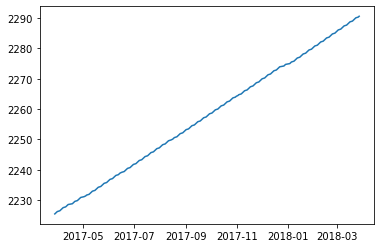

In [107]:
plt.plot(wig_20_plot['Data'], simple_preds)

(array([ 1.,  0.,  0.,  0.,  1.,  1.,  2.,  5.,  4.,  1.,  6.,  5., 16.,
        13., 21., 27., 21., 35., 22., 16., 15., 14.,  7.,  5.,  3.,  4.,
         2.,  2.,  0.,  2.]),
 array([-0.04533611, -0.04262867, -0.03992123, -0.03721379, -0.03450635,
        -0.03179892, -0.02909148, -0.02638404, -0.0236766 , -0.02096916,
        -0.01826172, -0.01555428, -0.01284684, -0.0101394 , -0.00743196,
        -0.00472453, -0.00201709,  0.00069035,  0.00339779,  0.00610523,
         0.00881267,  0.01152011,  0.01422755,  0.01693499,  0.01964242,
         0.02234986,  0.0250573 ,  0.02776474,  0.03047218,  0.03317962,
         0.03588706]),
 <a list of 30 Patch objects>)

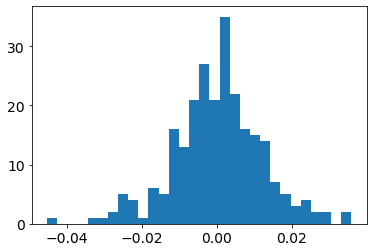

In [ ]:
||plt.hist(wig_20_daily_td['Returns'].values.flatten(), bins=30)
# wig_20_daily_td['Returns'].values.flatten().shape